In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose)
import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
import keras.backend as K
from wechat_utils import SendMessage
import itchat
import pdb

Using TensorFlow backend.


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.6'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train/'
mask_dir = '../data/train_masks/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [5]:
tmp_dir = './tmp/u-net-wechat/'

In [6]:
!mkdir ./tmp/u-net-wechat/

mkdir: cannot create directory ‘./tmp/u-net-wechat/’: File exists


In [7]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [8]:
input_dims = [32, 32]

In [9]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

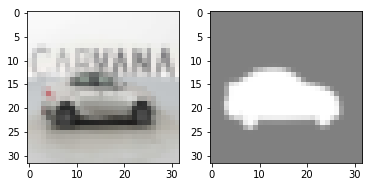

In [10]:
# Generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
    """
    data_dir: where the actual images are kept
    mask_dir: where the actual masks are kept
    images: the filenames of the images we want to generate batches from
    dims: the dimensions in which we want to rescale our images
    """
    if batch_size == 0:
        img_number = len(images)
        all_imgs = np.zeros([img_number] + dims + [3], dtype=np.float32)
        all_masks = np.zeros([img_number] + dims, dtype=np.float32)
        print('Build generator, this may take some time...')
        print('total number of images: {}'.format(img_number))
        for i, image in enumerate(tqdm(images)):
            # Image
            original_image = load_img(data_dir + image)
            resized_img = imresize(original_image, dims + [3])
            array_img = img_to_array(resized_img) / 255
            all_imgs[i] = array_img
            # Mask
            mask = load_img(mask_dir + image.split('.')[0] + '_mask.gif')
            resized = imresize(mask, dims + [3])
            array = img_to_array(resized) / 255
            all_masks[i] = array[:,:,0]
        while True:
            yield all_imgs, all_masks[:,:,:,None]
    else:
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 2, 
                          input_dims)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [11]:
class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by serializing
    call to the 'next' method of given iterator/generator.
    """
    def __init__(self, it):
        import threading
        self.it = it
        self.lock = threading.Lock()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return next(self.it)

In [12]:
%%time
_ = next(train_gen)

CPU times: user 180 ms, sys: 8 ms, total: 188 ms
Wall time: 217 ms


In [13]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, 2, input_dims)

In [14]:
_ = next(val_gen)

In [15]:
image_, mask_ = next(val_gen)
print (image_.shape)
print (mask_.shape)

(2, 32, 32, 3)
(2, 32, 32, 1)


In [16]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)

(2, 32, 32, 3)
(2, 32, 32, 1)


## Build the network

In [17]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool,residual
    else:
        return residual
    
def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same')(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        conv1)
    return conv2


In [18]:
K.clear_session()
# Make a custom U-nets implementation
filters = 256
input_layer = Input(shape=input_dims + [3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

# Down 3 32
d3, res3 = down(d2, filters)
residuals.append(res3)

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1
up1 = up(d5, residual=residuals[-1], filters=filters)

# Up 2,3,4
up_ = up1
for layer_i in range(3):
    up_ = up(up_, residual=residuals[-(layer_i + 2)], filters=filters)
    
# Out, or up 5
out = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up_)

model = Model(input_layer, out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 256)   7168        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 32, 256)   590080      conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 256)   0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [19]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [22]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
send_message = SendMessage(savelog=False)

Getting uuid of QR code.


██████████████████████████████████████████████████████████████████████████████
██              ████    ████    ████████  ██  ████  ██  ██████              ██
██  ██████████  ████  ████    ██████████  ██  ██████  ████████  ██████████  ██
██  ██      ██  ██      ██  ██      ██          ████  ██    ██  ██      ██  ██
██  ██      ██  ██  ██  ██    ██  ██  ██  ████  ████        ██  ██      ██  ██
██  ██      ██  ████  ████    ████  ██  ██████    ██    ██████  ██      ██  ██
██  ██████████  ██████    ██████  ██  ██  ██      ████  ██████  ██████████  ██
██              ██  ██  ██  ██  ██  ██  ██  ██  ██  ██  ██  ██              ██
████████████████████  ████          ██████  ██████    ██    ██████████████████
████████    ██    ██    ██████  ██  ████  ██████    ████████████████    ██████
██████    ██  ██      ██████████    ██████        ██  ██    ██      ████  ████
████  ██  ██    ██  ██      ██  ██      ████          ██        ██      ██  ██
████          ██  ██  ██  ██  ██  ██      ██  ██████

Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as LUO FAN


In [23]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', 
             metrics=[dice_coef])

In [24]:
os.write(1, str.encode('#####something\n'))

15

In [ ]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=4, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., validation_steps=inf, max_queue_size=4, steps_per_epoch=2, epochs=2, callbacks=[<keras.ca..., workers=1, validation_data=(array([[[..., initial_epoch=0)`
  # Remove the CWD from sys.path while we load stuff.
Start auto replying.


Epoch 1/2


In [81]:
csv_logger = CSVLogger(tmp_dir + 'training.2.log')

In [90]:
class DecreaseLearningRate(Callback):
    def on_train_begin(self, log={}):
        optimizer = self.model.optimizer
        lr = K.get_value(optimizer.lr)
        K.set_value(optimizer.lr, lr * 0.1)
        print ('decrease the learning rate to {}'.format(lr * 0.1))